## 0. Load Libraries

In [1]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import re

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Obtain data

In [3]:
listings_df = pd.read_csv("../data/raw/listings.csv")
reviews_df = pd.read_csv("../data/interim/final_ratings.csv")

In [4]:
listing_second_df = pd.read_csv("../data/raw/listings2.csv")

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (43,61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,lang,polarity
0,2539,55688172,2015-12-04,25160947,Peter,Great host,ENGLISH,0.6249
1,2539,97474898,2016-08-27,91513326,Liz,Nice room for the price. Great neighborhood. J...,ENGLISH,0.9228
2,2539,105340344,2016-10-01,90022459,Евгений,Very nice apt. New remodeled.,ENGLISH,0.4754
3,2539,133131670,2017-02-20,116165195,George,Great place to stay for a while. John is a gre...,ENGLISH,0.9231
4,2539,157777930,2017-06-04,1806142,Isaac,I really enjoyed my time here in deep south Br...,ENGLISH,0.9881


In [6]:
listings_df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

## 2. Feature Engineering

Trimming listing_second to usefull rows only

In [7]:
df_ld = listing_second_df.loc[:,['id','description', 
    'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
    'neighbourhood_group_cleansed', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
    'amenities', 'price', 'minimum_nights','instant_bookable', 'cancellation_policy', 
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value','host_identity_verified']]

### Merging with Polarity DF

In [8]:
X = df_ld.merge(reviews_df[['listing_id','reviewer_id','polarity']],left_on='id',right_on='listing_id',how='right')

In [9]:
df_ld = X.drop(['id'], axis = 1)

In [10]:
del(X)

### 1.Instant Bookable

In [11]:
df_ld['instant_bookable'].value_counts()

f    608907
t    444265
Name: instant_bookable, dtype: int64

Changing this field to binary

In [12]:
df_ld['instant_bookable'].replace('t',1, inplace=True)
df_ld['instant_bookable'].replace('f',0, inplace=True)

### 2. Reviews per month

In [13]:
listings_df['reviews_per_month'].isna().sum()

10488

We will impute these values with the mean.

In [14]:
listings_df['reviews_per_month'].describe()

count    39260.000000
mean         1.300503
std          1.563485
min          0.010000
25%          0.207500
50%          0.670000
75%          1.910000
max         19.360000
Name: reviews_per_month, dtype: float64

In [15]:
mean_reviews_per_month = listings_df['reviews_per_month'].mean()

In [16]:
listings_df['reviews_per_month'] = listings_df['reviews_per_month'].fillna(mean_reviews_per_month)

In [17]:
df_ld['reviews_per_month'] = listings_df['reviews_per_month'] 

### 3. Room type

In [18]:
listings_df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [19]:
df_ld['room_type'] = listings_df['room_type']

In [20]:
df_ld['room_type'] = df_ld['room_type'].astype('category')

In [21]:
df_test = pd.get_dummies(df_ld['room_type'],prefix='room_type')

In [22]:
df_ld = pd.concat((df_ld, df_test), axis=1).drop(['room_type'], axis=1)

### 5. Availability 365

Mean Centering Availability 365

In [23]:
mean_availability_365 = listings_df['availability_365'].mean()

In [24]:
std_availability_365 = listings_df['availability_365'].std()

In [25]:
listings_df['availability_365'].subtract(mean_availability_365)/std_availability_365

0        1.835879
1        1.835879
2        0.734517
3        1.835879
4        0.340111
5       -0.791017
6       -0.746367
7       -0.880317
8        0.295461
9       -0.880317
10       1.835879
11       0.756842
12      -0.560327
13       1.307523
14      -0.857992
15       1.307523
16       1.776346
17       0.161512
18       0.481502
19       1.389381
20       1.835879
21       1.501005
22      -0.880317
23      -0.783576
24      -0.880317
25       0.712193
26       1.709371
27       1.218223
28      -0.850550
29       0.652659
           ...   
49718    1.828437
49719    0.057329
49720    0.109420
49721   -0.850550
49722   -0.098945
49723    0.451735
49724    1.835879
49725   -0.880317
49726   -0.731484
49727   -0.500793
49728    0.414527
49729   -0.857992
49730   -0.776134
49731   -0.843109
49732    1.835879
49733   -0.500793
49734   -0.478469
49735   -0.716601
49736   -0.344519
49737    0.027562
49738    1.835879
49739    1.754021
49740    1.300081
49741    1.657280
49742    0

In [26]:
df_ld['availability_365'] = listings_df['availability_365'].subtract(mean_availability_365)/std_availability_365

### 6. Minimum Nights

In [27]:
listings_df['minimum_nights'] = pd.qcut(listings_df['minimum_nights'], 10, duplicates='drop' )

In [28]:
df_ld['minimum_nights'] = listings_df['minimum_nights']

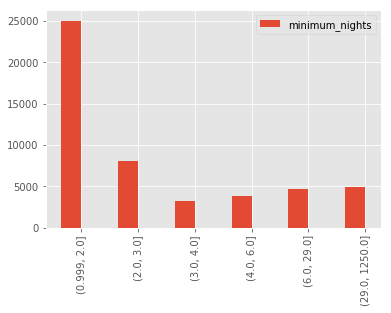

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

a = listings_df.groupby('minimum_nights').size()

categories = listings_df['minimum_nights'].cat.categories
ind = np.array([x for x, _ in enumerate(categories)])
width = 0.35       
plt.bar(ind, a, width, label='minimum_nights')

plt.xticks(ind + width / 2, categories)
plt.legend(loc='best')
plt.xticks(rotation = 90)
plt.show()

In [30]:
df_ld['minimum_nights'] = df_ld['minimum_nights'].astype('category')

In [31]:
df_test = pd.get_dummies(df_ld['minimum_nights'],prefix='minimum_nights')

In [32]:
df_ld = pd.concat((df_ld, df_test), axis=1).drop(['minimum_nights'], axis=1)

### 7. Price

In [33]:
listings_df['price'].describe()

count    49748.000000
mean       150.931796
std        225.025933
min          0.000000
25%         69.000000
50%        107.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [34]:
listings_df['price'] = pd.qcut(listings_df['price'], 10, duplicates='drop' )

In [35]:
df_ld['price'] = listings_df['price']

In [36]:
df_ld['price'] = df_ld['price'].astype('category')

In [37]:
df_ld = pd.concat((df_ld, pd.get_dummies(df_ld['price'],prefix='price')), axis=1).drop(['price'], axis=1)

### 8. Calculated Host Listings Count

In [38]:
listings_df['calculated_host_listings_count'].value_counts()

1      32254
2       7092
3       2898
4       1528
5        905
6        612
7        378
8        368
12       228
11       220
101      202
9        198
192      192
10       180
175      175
14       154
137      137
21       126
18       108
52       104
50       100
96        96
90        90
86        86
28        84
84        84
82        82
39        78
77        77
35        70
34        68
13        65
60        60
15        60
29        58
54        54
17        51
49        49
16        48
43        43
33        33
32        32
31        31
30        30
27        27
25        25
24        24
23        23
22        22
20        20
19        19
Name: calculated_host_listings_count, dtype: int64

In [39]:
#listings_df['calculated_host_listings_count'] = preprocessing.normalize([listings_df['calculated_host_listings_count']])

### 9. Is super host or not?

In [40]:
df_ld.host_is_superhost.value_counts()

f    624597
t    428559
Name: host_is_superhost, dtype: int64

changing this field to binary

In [41]:
df_ld.host_is_superhost.replace('t',1, inplace=True)
df_ld.host_is_superhost.replace('f',0, inplace=True)

In [42]:
df_ld.host_is_superhost.isna().sum()

16

In [43]:
df_ld = df_ld[df_ld['host_is_superhost'].isnull() == 0]

In [44]:
df_ld.host_is_superhost.corr(df_ld.review_scores_rating)

0.4860331163775283

### 10. Is the host verified?

In [45]:
df_ld.host_identity_verified.value_counts()

t    641937
f    411219
Name: host_identity_verified, dtype: int64

changing this field to binary

In [46]:
df_ld.host_identity_verified.replace('t',1, inplace=True)
df_ld.host_identity_verified.replace('f',0, inplace=True)

### 11. Cancellation Policy

In [47]:
df_ld.cancellation_policy.value_counts()

strict_14_with_grace_period    636982
moderate                       296451
flexible                       119203
super_strict_30                   257
super_strict_60                   200
strict                             63
Name: cancellation_policy, dtype: int64

In [48]:
df_ld['cancellation_policy'] = df_ld['cancellation_policy'].astype('category')

In [49]:
df_ld = pd.concat((df_ld, pd.get_dummies(df_ld['cancellation_policy'],prefix='cancellation_policy')), axis=1).drop(['cancellation_policy'], axis=1)

### 12. Does host respond on time?

In [50]:
df_ld.host_response_time.value_counts()

within an hour        704072
within a few hours    163213
within a day           80239
a few days or more     10938
Name: host_response_time, dtype: int64

In [51]:
df_ld.host_response_time.isna().sum()

94694

Imputing missing values

In [52]:
df_ld['host_response_time'].fillna(method='ffill', inplace=True)

In [53]:
df_ld.host_response_time.value_counts()

within an hour        756196
within a few hours    186168
within a day           96648
a few days or more     14144
Name: host_response_time, dtype: int64

Converting this into integer data type as it has an order to it

In [54]:
df_ld['host_response_time'].replace('within an hour', 1, inplace=True)
df_ld['host_response_time'].replace('within a few hours', 2, inplace=True)
df_ld['host_response_time'].replace('within a day', 3, inplace=True)
df_ld['host_response_time'].replace('a few days or more', 4, inplace=True)

### 13. Review Scores Rating

In [55]:
print(df_ld.review_scores_rating.isna().sum())
print(df_ld.review_scores_communication.isna().sum())
print(df_ld.review_scores_cleanliness.isna().sum())
print(df_ld.review_scores_location.isna().sum())
print(df_ld.review_scores_checkin.isna().sum())

11
42
34
74
68


In [56]:
df_ld = df_ld[df_ld['review_scores_rating'].isnull() == 0]
df_ld = df_ld[df_ld['review_scores_communication'].isnull() == 0]
df_ld = df_ld[df_ld['review_scores_cleanliness'].isnull() == 0]
df_ld = df_ld[df_ld['review_scores_location'].isnull() == 0]
df_ld = df_ld[df_ld['review_scores_checkin'].isnull() == 0]

In [57]:
print(df_ld.review_scores_communication.corr(df_ld.review_scores_rating))
print(df_ld.review_scores_cleanliness.corr(df_ld.review_scores_rating))
print(df_ld.review_scores_location.corr(df_ld.review_scores_rating))
print(df_ld.review_scores_checkin.corr(df_ld.review_scores_rating))

0.5865628799281731
0.7086475070755279
0.33188623683904017
0.53213321679505


Cleanliness is one of the highest important factors and location the least.

### 14. Ameneties

How many amenities are present?

In [58]:
df_ld.loc[:,'amenities_len'] = df_ld['amenities'].str.len()

In [59]:
df_ld = df_ld.drop(['amenities'], axis=1)

In [60]:
df_ld.amenities_len.corr(df_ld.review_scores_rating)

0.20186814375171921

In [61]:
df_ld.sample(frac=0.000001,random_state=42).shape

(1, 50)

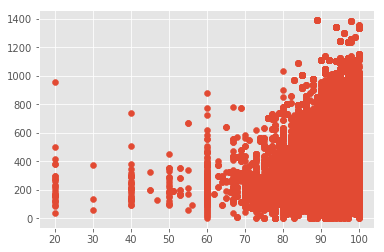

In [62]:
matplotlib.style.use('ggplot')
plt.scatter('review_scores_rating','amenities_len',
            data=df_ld.sample(frac=0.3,random_state=42))
plt.show()

Number of amenities do not matter, quality of amenities matter.

### 15. Description length

In [63]:
df_ld.loc[:,'description_len'] = df_ld['description'].str.len()

In [64]:
df_ld = df_ld.drop(['description'], axis=1)

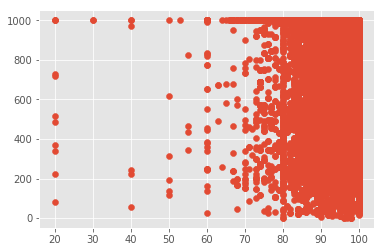

In [65]:
matplotlib.style.use('ggplot')
plt.scatter('review_scores_rating','description_len',data=df_ld.sample(frac=0.1,random_state=34))
plt.show()

### 16. Neighbourhood Group

In [66]:
df_ld.neighbourhood_group_cleansed = df_ld[~df_ld.neighbourhood_group_cleansed.isna()]

In [67]:
df_ld['neighbourhood_group_cleansed'] = df_ld['neighbourhood_group_cleansed'].astype('category')

In [68]:
df_ld = pd.concat((df_ld, pd.get_dummies(df_ld['neighbourhood_group_cleansed'],prefix='neighbourhood_group_cleansed')), axis=1).drop(['neighbourhood_group_cleansed'], axis=1)

# Visualizations

## Correlation Matrix

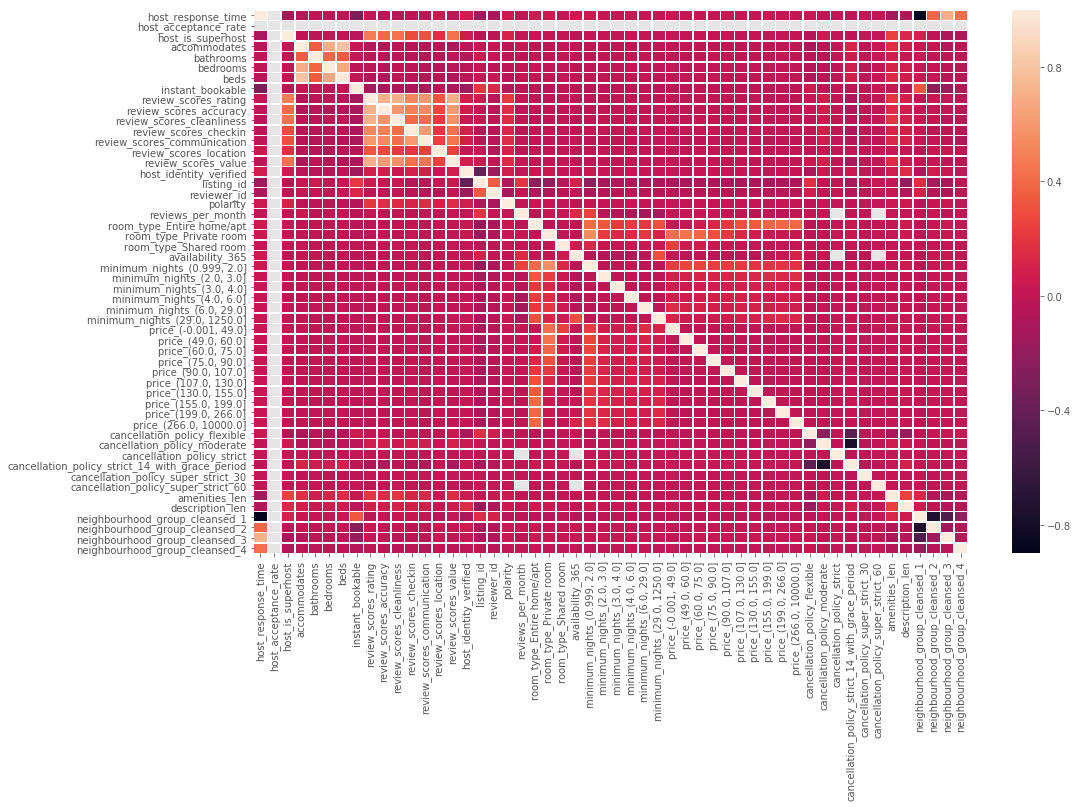

In [71]:
fig, ax = plt.subplots(figsize=(16,10))
corr = df_ld.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, linewidths=.5, ax=ax)

In [72]:
corr['review_scores_rating'].sort_values(ascending=False)

review_scores_rating                               1.000000
review_scores_accuracy                             0.717549
review_scores_cleanliness                          0.708648
review_scores_value                                0.696884
review_scores_communication                        0.586563
review_scores_checkin                              0.532133
host_is_superhost                                  0.486409
review_scores_location                             0.331886
polarity                                           0.210365
amenities_len                                      0.201868
host_identity_verified                             0.086962
description_len                                    0.086278
cancellation_policy_moderate                       0.078829
listing_id                                         0.051550
neighbourhood_group_cleansed_2                     0.020550
cancellation_policy_super_strict_30                0.011210
cancellation_policy_flexible            

## Ratings vs. Host Response Rate by Super Host

In [73]:
df_ld.host_response_rate = df_ld.host_response_rate.replace('%','',regex=True)
df_ld.host_response_rate = df_ld.host_response_rate.astype('float64')/100.00

In [74]:
df_ld.host_response_rate.isna().sum()

94620

In [75]:
df_ld['host_response_rate'].fillna(method='ffill', inplace=True)

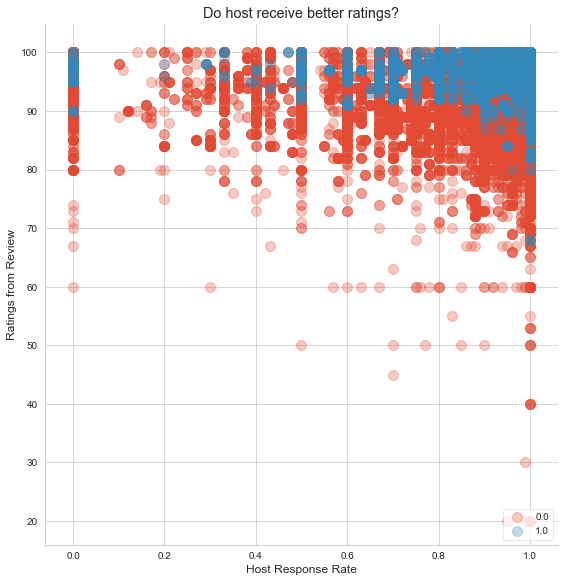

In [76]:
sns.set_style("whitegrid")
g = sns.lmplot(x="host_response_rate", y="review_scores_rating", data=df_ld.sample(frac=0.1, random_state=42), fit_reg=False,
           hue='host_is_superhost', legend=False,
           scatter_kws={"alpha":0.3,"s":100}, height=8)

g =  (g.set_axis_labels("Host Response Rate","Ratings from Review"))

plt.title("Do host receive better ratings?")
plt.legend(loc='lower right')

## Distribution of Airbnb Reviews

In [78]:
print('Number of neighborhoods in data:',listing_second_df['neighbourhood_group_cleansed'].nunique())

Number of neighborhoods in data: 5


In [83]:
listing_second_df['neighbourhood_group_cleansed'].value_counts().to_frame()[0:20]

,neighbourhood_group_cleansed
Manhattan,22559
Brooklyn,20312
Queens,5525
Bronx,1001
Staten Island,351


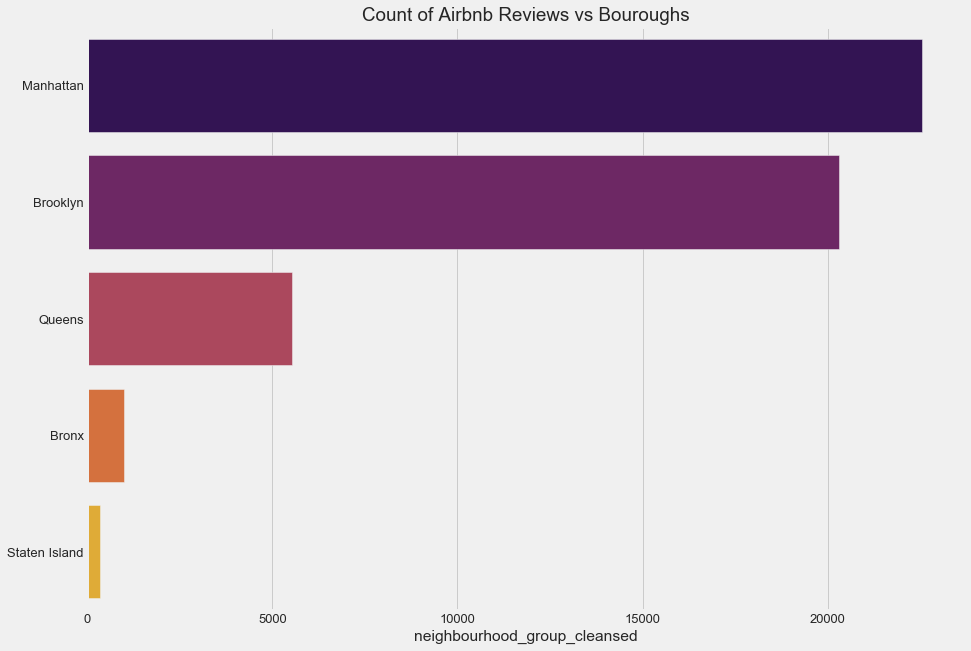

In [111]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size':13})
plt.figure(figsize=(14,10))
display_fig = listing_second_df['neighbourhood_group_cleansed'].value_counts().to_frame()
#plt.xscale('log')
sns.barplot(x= display_fig['neighbourhood_group_cleansed'], y =display_fig.index, data=display_fig, palette='inferno',orient='h')
plt.title('Count of Airbnb Reviews vs Bouroughs');


## Borough wise highest and lowest ratings received for Airbnb Listings

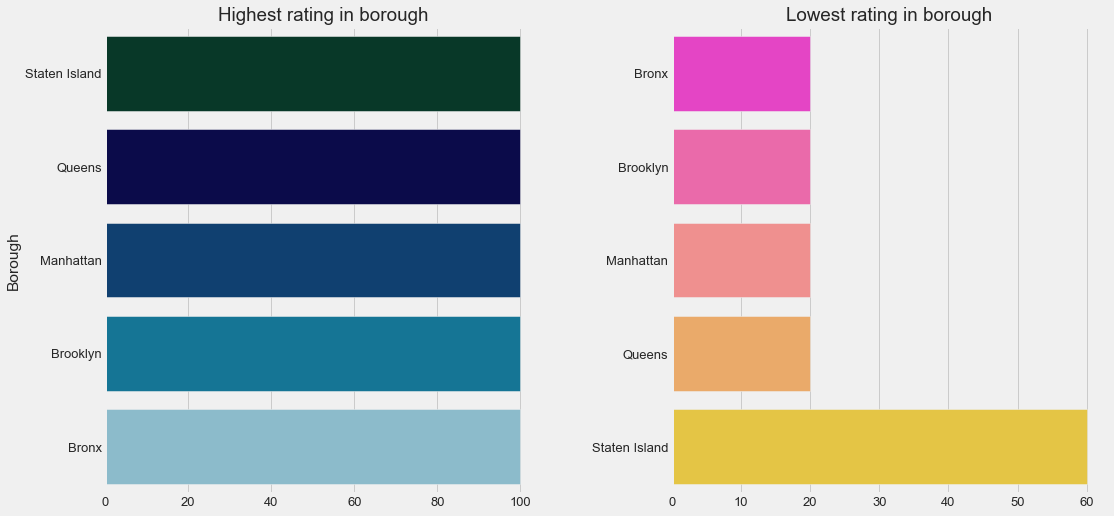

In [99]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
display_fig = listing_second_df.groupby(['neighbourhood_group_cleansed'])['review_scores_rating'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = display_fig['review_scores_rating'], y = display_fig.index, palette= 'ocean',ax=ax1)
ax1.set_title('Highest rating in borough')
ax1.set_ylabel('Borough')
ax1.set_xlabel('')
display_fig = listing_second_df.groupby(['neighbourhood_group_cleansed'])['review_scores_rating'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = display_fig['review_scores_rating'], y = display_fig.index, palette = 'spring',ax=ax2)
ax2.set_title('Lowest rating in borough')
ax2.set_ylabel('')
ax2.set_xlabel('')
plt.subplots_adjust(wspace=0.3);

There is no real correlation between ratings and boroughs

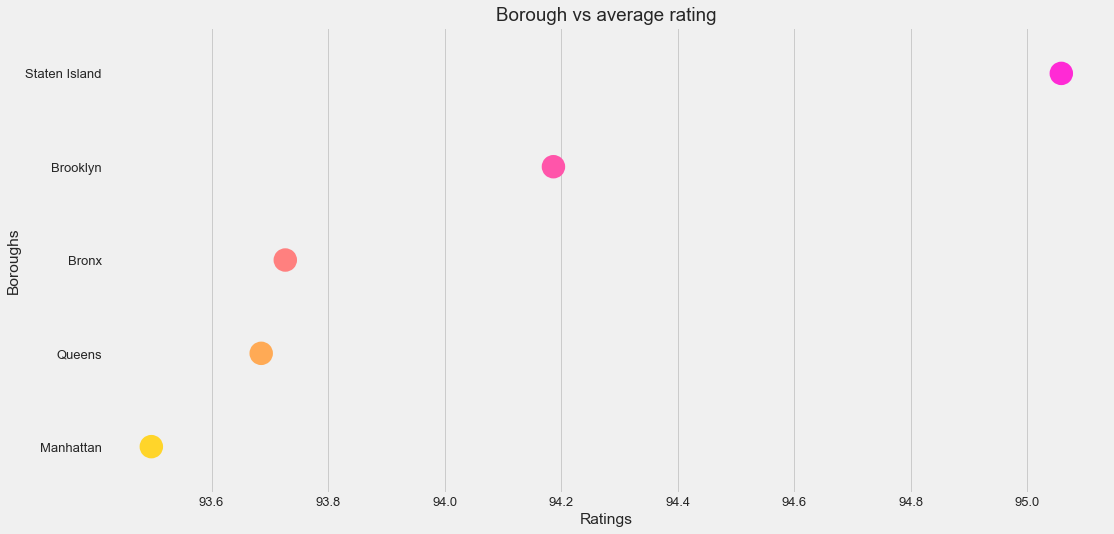

In [107]:
display_fig = listing_second_df.groupby(['neighbourhood_group_cleansed',]).mean()['review_scores_rating'].sort_values(ascending=False).to_frame()

plt.figure(figsize=(16,8))
sns.pointplot(x = display_fig['review_scores_rating'] ,y = cnt.index ,palette = 'spring',orient='h')
plt.title('Borough vs average rating')
plt.xlabel('Ratings');
plt.ylabel('Boroughs');

In [119]:
print('Number of unique listings :',reviews_df.listing_id.nunique())
print('Number of unique listings :',reviews_df.reviewer_id.nunique())

Number of unique listings : 38103
Number of unique listings : 917021


# Write file to CSV

In [89]:
new_df_ld = df_ld.drop(['review_scores_rating','review_scores_communication',
               'review_scores_cleanliness','review_scores_location','review_scores_checkin',
               'review_scores_accuracy', 'review_scores_value' ], axis = 1)

In [93]:
regex = re.compile(r"\[|\]|<|\(", re.IGNORECASE)

In [97]:
new_df_ld.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '('))) 
                 else col for col in new_df_ld.columns.values]

In [98]:
new_df_ld.to_csv("../data/interim/listingplusreviewfinal.csv", index = False)